In [1]:
import random
import os
import numpy as np
import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import itertools
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage import img_as_ubyte

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet

2024-06-10 10:44:34.422608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 10:44:34.578126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 10:44:34.580073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [2]:
random.seed(43)
tf.random.set_seed(43)

In [3]:
tf.keras.backend.clear_session()
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'

In [4]:
data_path = '/home/timihack/Documents/ML/BrainCancer/data/brain_tumor_dataset/'
!ls '/home/timihack/Documents/ML/BrainCancer/archive/brain_tumor_dataset/'

ls: cannot access '/home/timihack/Documents/ML/BrainCancer/archive/brain_tumor_dataset/': No such file or directory


In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def view_image(path, tclass):
    folder = os.path.join(path, tclass)
    random_image = random.sample(os.listdir(folder), 2)
    img = mpimg.imread(folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(tclass)
    plt.axis('off')
    print(f'Image shape: {img.shape}')

Image shape: (225, 225, 3)


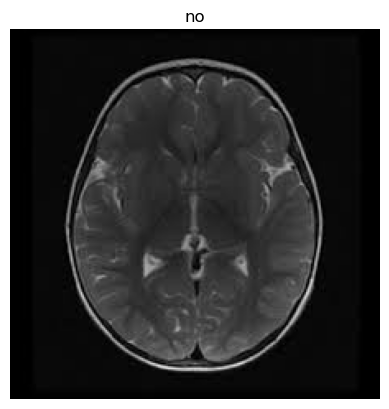

In [6]:
view_image(data_path, 'no')

Image shape: (1280, 1061, 3)


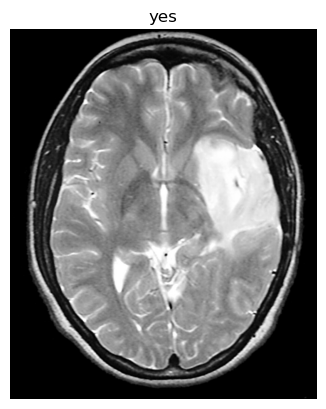

In [7]:
view_image(data_path, 'yes')

In [8]:
class Preprocess:
    def __init__(self, train_data, test_data=None, target_size=(224, 224), batch_size=8, validation_split=0.1, 
                 horizontal_flip=False, vertical_flip=False, 
                 zoom_range=0.05, rotation_range=45,
                 seed=23, class_mode='binary', color_mode='rgb', shuffle=False):
        self.train_data = train_data
        self.test_data = test_data
        self.target_size = target_size
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.zoom_range = zoom_range
        self.rotation_range = rotation_range
        self.seed = seed
        self.class_mode = class_mode
        self.color_mode = color_mode
        self.shuffle = shuffle
        self.train_generator = None
        self.test_generator = None
        
        
    def augument_data(self):
        def custom_augmentation(image):
            preprocessed = tf.keras.applications.mobilenet.preprocess_input(image)
            # Apply custom augmentation to the image
#             filtered_image = self.filter_image(image)
#             masked_image = self.mask_image(image)
#             augmented_image = tf.concat([filtered_image, masked_image], axis=2)
            return preprocessed
        
        train_generator = ImageDataGenerator(
            rescale=1/255,
            validation_split=self.validation_split,
            horizontal_flip=self.horizontal_flip,
            vertical_flip=self.vertical_flip,
            zoom_range=self.zoom_range,
            rotation_range=self.rotation_range,
#             preprocessing_function=custom_augmentation
        )
        
        if self.test_data:
            test_generator = ImageDataGenerator(
                rescale=1/255
            )
        else:
            test_generator = None
        
        return train_generator, test_generator
    
#     def filter_image(self, image):
#         # Apply a filter to the image (e.g., Gaussian filter)
#         filtered_image = gaussian(image, sigma=1.5, multichannel=True)
#         return filtered_image

#     def mask_image(self, image):
#         # Create a mask for the image
#         mask = np.zeros_like(image)
#         h, w, _ = image.shape
#         mask[h//4:3*h//4, w//4:3*w//4, :] = 1
#         masked_image = image * mask
#         return masked_image

    
    def generate(self):
        train_data = self.train_generator.flow_from_directory(
            self.train_data,
            batch_size=self.batch_size,
            target_size=self.target_size,
            class_mode=self.class_mode,
            color_mode=self.color_mode,
            shuffle=self.shuffle,
            seed=self.seed,
            subset='training'
        )
        val_data = self.train_generator.flow_from_directory(
            self.train_data,
            batch_size=self.batch_size,
            target_size=self.target_size,
            class_mode=self.class_mode,
            color_mode=self.color_mode,
            shuffle=False,
            seed=self.seed,
            subset='validation'
        )
        
        
        if self.test_data:
            test_data = self.test_generator.flow_from_directory(
                self.test_data,
                batch_size=self.batch_size,
                target_size=self.target_size,
                class_mode=self.class_mode,
                color_mode=self.color_mode,
                shuffle=False,
                seed=self.seed
            )
        else:
            test_data = None
            
        return train_data, val_data, test_data
    
    def run(self):
        self.train_generator, self.test_generator = self.augument_data()
        self.train_data, self.val_data, self.test_data = self.generate()
        print('Preprocessing completed')
        return self.train_data, self.val_data, self.test_data

In [9]:
preprocessor = Preprocess(data_path, validation_split=0.2, shuffle=True, vertical_flip=True)
train_data, val_data, _ = preprocessor.run()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Preprocessing completed


In [10]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable=False

model = keras.models.Sequential([
    base_model,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 32)                18464     
                                                        

In [13]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=10,
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='brain_tumor.keras',
    save_best_only=True,
    save_weights_only=True
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model_history =model.fit(train_data,
                         epochs=20,
                         batch_size=8, 
                         validation_data=val_data,
                        callbacks=[early_stop, checkpoint])

Epoch 1/20
26/26 [==============================] - 43s 1s/step - loss: 0.8414 - accuracy: 0.6502 - val_loss: 0.9617 - val_accuracy: 0.7200
Epoch 2/20
26/26 [==============================] - 39s 1s/step - loss: 0.5112 - accuracy: 0.8030 - val_loss: 0.3799 - val_accuracy: 0.8800
Epoch 3/20
26/26 [==============================] - 37s 1s/step - loss: 0.3887 - accuracy: 0.8424 - val_loss: 0.3894 - val_accuracy: 0.8800
Epoch 4/20
26/26 [==============================] - 38s 1s/step - loss: 0.4310 - accuracy: 0.8818 - val_loss: 0.3222 - val_accuracy: 0.8800
Epoch 5/20
26/26 [==============================] - 37s 1s/step - loss: 0.3246 - accuracy: 0.8719 - val_loss: 0.3165 - val_accuracy: 0.9000
Epoch 6/20
26/26 [==============================] - 33s 1s/step - loss: 0.2950 - accuracy: 0.9015 - val_loss: 0.3268 - val_accuracy: 0.8800
Epoch 7/20
26/26 [==============================] - 33s 1s/step - loss: 0.3900 - accuracy: 0.8374 - val_loss: 0.2470 - val_accuracy: 0.9000
Epoch 8/20
26/26 [==

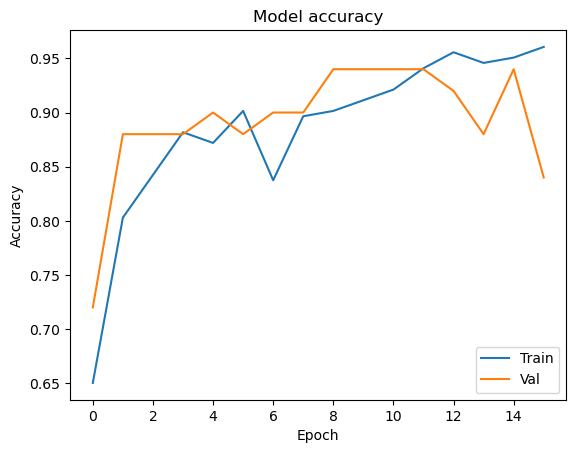

In [14]:
# Plot the training and validation accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

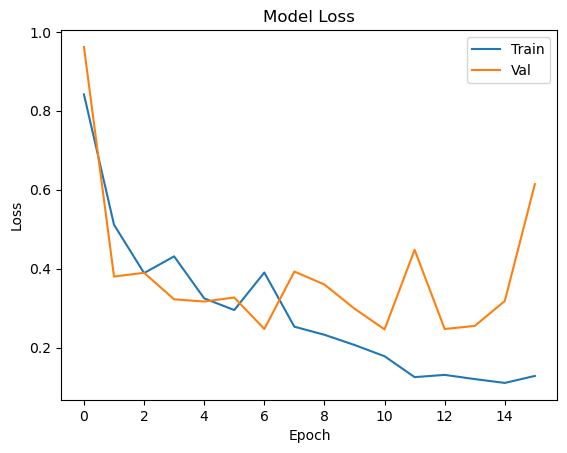

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [16]:
# model.save('brain_cancer.keras')
model = tf.keras.models.load_model('brain_cancer.keras')

In [26]:
import cv2

def load_image(img_name):
    file_path = 'data/test'
    img = cv2.imread(os.path.join(file_path, img_name), cv2.IMREAD_COLOR)
    img = img.astype('float32') / 255.0
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def display(img):
    plt.imshow(img.squeeze())  # Use squeeze to remove single-dimensional entries from the shape
    plt.axis('off')  # Turn off axis
    plt.show()
    
def predict(img):
    pred = model.predict(img)
    if pred[0][0] > 0.5:
        return True
    else:
        return False

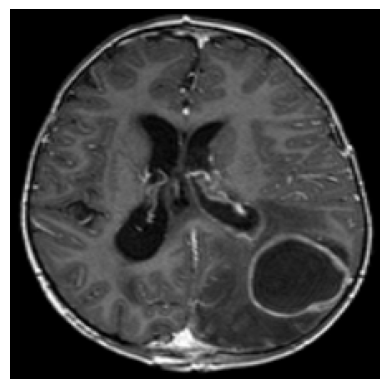

1/1 [==============================] - 0s 148ms/step


Predicted class: Yes


In [28]:
img = load_image('yes/Y257.jpg')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")

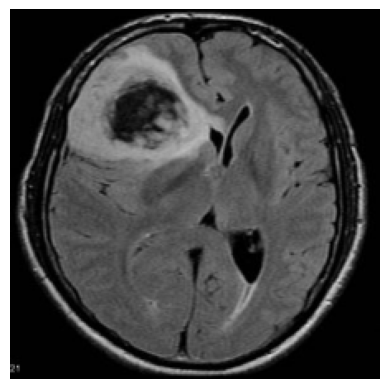

1/1 [==============================] - 0s 159ms/step


Predicted class: Yes


In [29]:
img = load_image('yes/Y258.JPG')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")

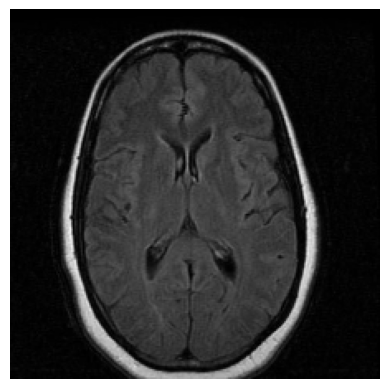

1/1 [==============================] - 0s 191ms/step


Predicted class: No


In [30]:
img = load_image('no/No20.jpg')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")

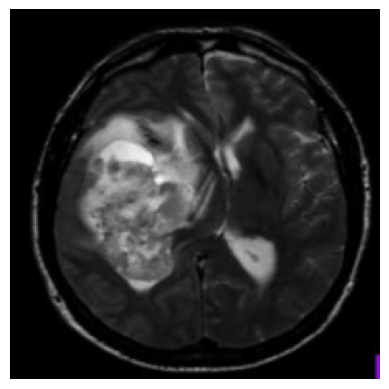

1/1 [==============================] - 0s 187ms/step


Predicted class: Yes


In [31]:
img = load_image('yes/Y259.JPG')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")

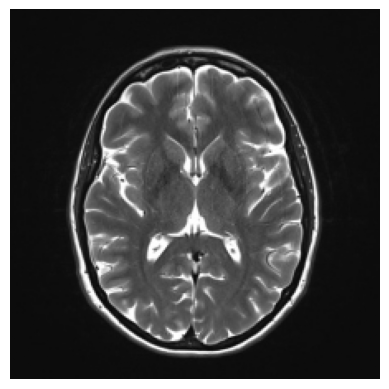

1/1 [==============================] - 0s 153ms/step


Predicted class: No


In [32]:
img = load_image('no/No21.jpg')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")

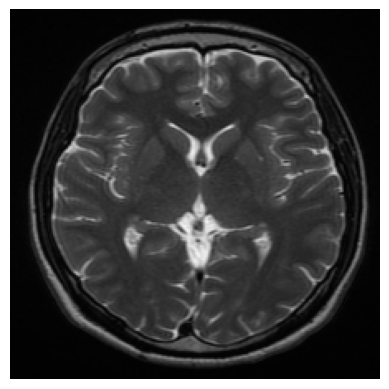

1/1 [==============================] - 0s 155ms/step


Predicted class: No


In [33]:
img = load_image('no/No22.jpg')
display(img)
pred = predict(img)

if pred:
     print("\n\nPredicted class: Yes")
else:
    print("\n\nPredicted class: No")